In [ ]:
!pip install torcheval

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoModel
from transformers.optimization import get_linear_schedule_with_warmup


import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.clip_grad import clip_grad_norm_

In [ ]:
enem_data = pd.read_pickle("enem_data_embeddings_100.pkl")
enem_data.dropna(subset=["nu_param_B", "enunciado"], inplace=True)
enem_data.head()

,numero_questao,gabarito,NU_PARAM_A,nu_param_B,NU_PARAM_C,ANO,enunciado,alternativas,gabarito_texto,distratores,enunciado_limpo,alternativas_limpo,gabarito_texto_limpo,distratores_limpo,enunciado_embeddings_word2vec,gabarito_embeddings_word2vec
0,1,C,3.43894,0.97831,0.10855,2017,"No império africano do Mali, no século XIV, To...",A: isolamento geográﬁco do Saara ocidental; B...,posição relativa nas redes de circulação,isolamento geográﬁco do Saara ocidental; explo...,africano além astronomia centro cidade comérci...,A: isolamento ocidental saara; B: exploração i...,circulação posição redes relativa,competição econômica exploração intensiva isol...,"[0.061125945, -0.048051268, -0.059038285, 0.05...","[0.0875405, 0.14673425, 0.17936975, -0.0332287..."
1,2,D,3.00837,0.49169,0.13877,2017,Após a Declaração Universal dos Direitos Human...,A: ataque feito pelos japoneses à base milita...,execução de judeus e eslavos presos em guetos ...,ataque feito pelos japoneses à base militar am...,aberrações acontecimentos após assumida branco...,A: americana ataque base feito harbor japonese...,campos concentração eslavos execução guetos ju...,americana americanas ataque atômicas base bomb...,"[0.009677129, 0.11954352, 0.021252066, -0.0227...","[0.16129163, 0.23760912, 0.080258876, -0.05254..."
2,3,D,0.60432,3.25992,0.08798,2017,"A moralidade, Bentham exortava, não é uma ques...",A: fundamentação cientíﬁca de viés positivist...,racionalidade de caráter pragmático,fundamentação cientíﬁca de viés positivista; c...,abstratas afetados agradar ação bentham condut...,A: fundamentação positivista viés; B: convençã...,caráter pragmático racionalidade,comportamental convenção fundamentação inclina...,"[0.068149306, -0.023954527, 0.02739678, -0.003...","[0.26195732, -0.13758467, -0.16108766, 0.07133..."
3,4,E,1.85031,0.57925,0.11344,2017,Fala-se muito nos dias de hoje em direitos do ...,A: modernização da educação escolar; B: atuali...,universalização do princípio da igualdade civil,modernização da educação escolar; atualização ...,apresenta assembleia bases bem cidadão concepç...,A: educação escolar modernização; B: atualizaç...,civil igualdade princípio universalização,aristocráticos atualização conhecimento costum...,"[0.019322807, -0.034913678, -0.00591799, 0.012...","[0.253879, -0.005192494, -0.028254755, 0.10982..."
4,5,C,2.46290,0.76307,0.17672,2017,Na Constituição da República Federativa do Bra...,A: etnia e miscigenação racial; B: sociedade...,espaço e sobrevivência cultural,etnia e miscigenação racial; sociedade e igual...,aplicação artigo bens brasil competindo consta...,A: etnia miscigenação racial; B: igualdade jur...,cultural espaço sobrevivência,ambiental bem econômica educação etnia igualda...,"[-0.032498874, 0.08808657, -0.040701427, 0.077...","[0.248065, -0.15562867, -0.114118, -0.12127533..."


## Tokenização (BERT Portuguese)



In [ ]:
data = enem_data[["enunciado", "nu_param_B"]]
data.head()

,enunciado,nu_param_B
0,"No império africano do Mali, no século XIV, To...",0.97831
1,Após a Declaração Universal dos Direitos Human...,0.49169
2,"A moralidade, Bentham exortava, não é uma ques...",3.25992
3,Fala-se muito nos dias de hoje em direitos do ...,0.57925
4,Na Constituição da República Federativa do Bra...,0.76307


In [ ]:
# Tokenizando os textos do enunciado

tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased", do_lower_case=False)

encoded_corpus = tokenizer(text=data.enunciado.tolist(),
                           add_special_tokens=True,
                           padding="max_length",
                           truncation="longest_first",
                           max_length=512,
                           return_attention_mask=True)

# Coletando input_ids (features)
input_ids = encoded_corpus["input_ids"]
attention_mask = encoded_corpus["attention_mask"]

# Coletando labels (target)
labels = data.nu_param_B.to_numpy()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Separando dados para validação (20% para validação / 80% para treino e teste)
seed = 42

train_and_test_inputs, val_inputs, train_and_test_labels, val_labels = train_test_split(input_ids, labels, test_size = 0.2, random_state=seed)
train_and_test_masks, val_masks, _, _ = train_test_split(attention_mask, labels, test_size=0.2, random_state=seed)

In [ ]:
# Separando treino e teste (10% dos dados para teste/ 90% para treino)

train_inputs, test_inputs, train_labels, test_labels = train_test_split(train_and_test_inputs, train_and_test_labels, test_size = 0.1, random_state=seed)
train_masks, test_masks, _, _ = train_test_split(train_and_test_masks, train_and_test_labels, test_size=0.1, random_state=seed)

In [ ]:
# Convertendo os dados em DataLoader (Aceitos pelo Pytorch)

batch_size = 8

def create_dataloaders(inputs, masks, labels, batch_size):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    labels_tensor = torch.tensor(labels)

    dataset = TensorDataset(input_tensor, mask_tensor,
                            labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size,
                            shuffle=True)
    return dataloader

train_dataloader = create_dataloaders(train_inputs, train_masks,
                                      train_labels, batch_size)
test_dataloader = create_dataloaders(test_inputs, test_masks,
                                     test_labels, batch_size)

## BERTimbau Regressor

In [ ]:
# Definindo classe Bert + Camada de Regressão

class BertimbauRegressor(nn.Module):

  def __init__(self, drop_rate=0.2, freeze_bertimbau=False):
    super(BertimbauRegressor, self).__init__()
    D_in, D_out = 768, 1

    # Pre-trained BERTimbau Neural Network
    self.bertimbau = AutoModel.from_pretrained("neuralmind/bert-base-portuguese-cased")

    # Regressor Layer (Takes 768 input from pre-trained BERT and outputs one value)
    self.regressor = nn.Sequential(nn.Dropout(drop_rate), nn.Linear(D_in, D_out))
    self.double()

  def forward(self, input_ids, attention_masks):
    outputs = self.bertimbau(input_ids=input_ids, attention_mask=attention_masks)
    class_label_output = outputs[1]
    outputs = self.regressor(class_label_output)
    return outputs

In [ ]:
model = BertimbauRegressor(drop_rate=0.2)

## Setting up Training Environment

In [ ]:
torch.cuda.empty_cache()

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print(f"Training on GPU: {torch.cuda.get_device_name(0)}")
else:
  print(f"No GPU available, using CPU.")
  device = torch.device("cpu")

Training on GPU: Tesla T4


In [ ]:
model.to(device)

BertimbauRegressor(
  (bertimbau): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

## Training Phase

In [ ]:
def r2_score(outputs, labels):
    labels_mean = torch.mean(labels)
    ss_tot = torch.sum((labels - labels_mean) ** 2)
    ss_res = torch.sum((labels - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [ ]:
def train(model, optimizer, scheduler, loss_function, epochs, train_dataloader, test_dataloader, device, clip_value=2):

  # Métricas de treino total (valor por época)
  loss_list = []
  rmse_list = []
  r2_train_list = []
  epoch_list = []

  # Métricas de teste total (valor por época)
  test_loss_list = []
  test_rmse_list = []
  r2_test_list = []

  best_loss = 1e10

  for epoch in range(epochs):
      # Métricas de treino em uma época (valor por batch)
      batch_loss_list = []
      batch_rmse_list = []
      train_preds = []
      train_labels = []

      print("\n--------")
      print("Epoch: ", epoch)

      model.train()
      for step, batch in enumerate(train_dataloader):
          batch_inputs, batch_masks, batch_labels = tuple(b.to(device) for b in batch)

          model.zero_grad()
          outputs = model(batch_inputs, batch_masks)

          loss = loss_function(outputs.squeeze(), batch_labels.squeeze())
          rmse = torch.sqrt(loss)

          loss.backward()
          clip_grad_norm_(model.parameters(), max_norm=clip_value)
          optimizer.step()
          scheduler.step()

          print("   Batch: ", step, "    Loss:", loss.cpu().detach().numpy(), "    RMSE:", rmse.cpu().detach().numpy())

          batch_loss_list.append(loss)
          batch_rmse_list.append(rmse)
          epoch_list.append(epoch)

          # Salvando predições para R2
          train_preds.append(outputs.squeeze().detach())
          train_labels.append(batch_labels.squeeze().detach())

      # Calcular R2 de treino
      train_preds = torch.cat(train_preds)
      train_labels = torch.cat(train_labels)
      r2_train = r2_score(train_preds, train_labels)
      r2_train_list.append(r2_train)

      # Inicializa métricas de teste
      test_loss = 0
      test_rmse = 0
      test_preds = []
      test_labels = []

      model.eval()
      with torch.no_grad():
          for i, test_data in enumerate(test_dataloader):
              test_inputs, test_masks, batch_labels = tuple(b.to(device) for b in test_data)
              test_outputs = model(test_inputs, test_masks)

              loss_item = loss_function(test_outputs.squeeze(), batch_labels.squeeze())
              test_loss += loss_item
              test_rmse += torch.sqrt(loss_item)

              test_preds.append(test_outputs.squeeze())
              test_labels.append(batch_labels.squeeze())

      # Calcular R² de teste
      test_preds = torch.cat(test_preds)
      test_labels = torch.cat(test_labels)
      r2_test = r2_score(test_preds, test_labels)
      r2_test_list.append(r2_test)

      # Cálculo das médias
      media_loss_treino = sum(batch_loss_list) / len(batch_loss_list)
      media_rmse_treino = sum(batch_rmse_list) / len(batch_rmse_list)
      loss_list.append(media_loss_treino)
      rmse_list.append(media_rmse_treino)

      media_loss_teste = test_loss / (i + 1)
      media_rmse_teste = test_rmse / (i + 1)
      test_loss_list.append(media_loss_teste)
      test_rmse_list.append(media_rmse_teste)

      if media_loss_treino < best_loss:
          best_loss = media_loss_treino
          torch.save(model.state_dict(), "bert_model.pht")

      print("MSE Train: ", media_loss_treino.cpu().detach().numpy(), "  Test: ", media_loss_teste.cpu().detach().numpy())
      print("RMSE Train: ", media_rmse_treino.cpu().detach().numpy(), "  Test: ", media_rmse_teste.cpu().detach().numpy())
      print("R2 Train: ", r2_train.cpu().detach().numpy(), "  Test: ", r2_test.cpu().detach().numpy())

  return model, loss_list, rmse_list, test_loss_list, test_rmse_list, r2_train_list, r2_test_list, best_loss


In [ ]:
# Definindo o otimizador como o BERT original
optimizer = torch.optim.AdamW(model.parameters(), lr= 3e-5, eps=1e-8) # Same as BERT Paper

# MSE loss is the most common for Regression Tasks
loss_function = nn.MSELoss()

# Definindo número de épocas
epochs = 8
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Treinamento
model, loss_list, rmse_list, test_loss_list, test_rmse_list, r2_train_list, r2_test_list, best_loss = train(model, optimizer, scheduler, loss_function, epochs, train_dataloader, test_dataloader, device, clip_value=2)


--------
Epoch:  0
   Batch:  0     Loss: 1.642994609928877     RMSE: 1.2817935129843951
   Batch:  1     Loss: 1.0979726311764886     RMSE: 1.047841892260702
   Batch:  2     Loss: 1.439465821915219     RMSE: 1.1997774051528138
   Batch:  3     Loss: 0.6391994875484818     RMSE: 0.79949952316964
   Batch:  4     Loss: 0.8029633352288361     RMSE: 0.8960822145477703
   Batch:  5     Loss: 0.6246746614493099     RMSE: 0.7903636260920096
   Batch:  6     Loss: 0.33261570041237654     RMSE: 0.5767284459885575
   Batch:  7     Loss: 1.0186732956143794     RMSE: 1.0092934635745836
   Batch:  8     Loss: 0.07349489345421956     RMSE: 0.2710994161819969
   Batch:  9     Loss: 0.6927663562647935     RMSE: 0.8323258714378603
   Batch:  10     Loss: 0.3900075541599028     RMSE: 0.6245058479789463
   Batch:  11     Loss: 0.6575660360521266     RMSE: 0.8109044555631241
   Batch:  12     Loss: 0.5504181772544202     RMSE: 0.7419017301869704
   Batch:  13     Loss: 0.4054997618252737     RMSE: 0.63

In [ ]:
print("Melhor RMSE de Treino: ", min(rmse_list).cpu().detach().numpy())
print("Melhor RMSE de Teste: ", min(test_rmse_list).cpu().detach().numpy())
print("Melhor R2 de Treino: ", max(r2_train_list).cpu().detach().numpy())
print("Melhor R2 de Teste: ", max(r2_test_list).cpu().detach().numpy())

NameError: name 'rmse_list' is not defined

In [ ]:
loss_list_complete = []
rmse_list_complete = []
r2_list_complete = []
test_loss_list_complete = []
test_rmse_list_complete = []
test_r2_list_complete = []

for value in loss_list:
  loss_list_complete.append(float(value.cpu().detach().numpy()))

for value in rmse_list:
  rmse_list_complete.append(float(value.cpu().detach().numpy()))

for value in r2_train_list:
  r2_list_complete.append(float(value.cpu().detach().numpy()))

for value in test_loss_list:
  test_loss_list_complete.append(float(value.cpu().detach().numpy()))

for value in test_rmse_list:
  test_rmse_list_complete.append(float(value.cpu().detach().numpy()))

for value in r2_test_list:
  test_r2_list_complete.append(float(value.cpu().detach().numpy()))

In [ ]:
dict_results = {"loss_list": loss_list_complete, "rmse_list": rmse_list_complete, "r2_list": r2_list_complete,"test_loss_list": test_loss_list_complete, "test_rmse_list": test_rmse_list_complete, "test_r2_list": test_r2_list_complete}
df_results = pd.DataFrame(dict_results)

df_results.head(3)

,loss_list,rmse_list,r2_list,test_loss_list,test_rmse_list,test_r2_list
0,0.648628,0.766232,-0.298504,0.420935,0.613586,0.076332
1,0.425550,0.614111,0.148847,0.284952,0.507706,0.352724
2,0.366816,0.576488,0.270488,0.459162,0.653968,0.011000


In [ ]:
df_results.to_pickle("df_results.pkl")

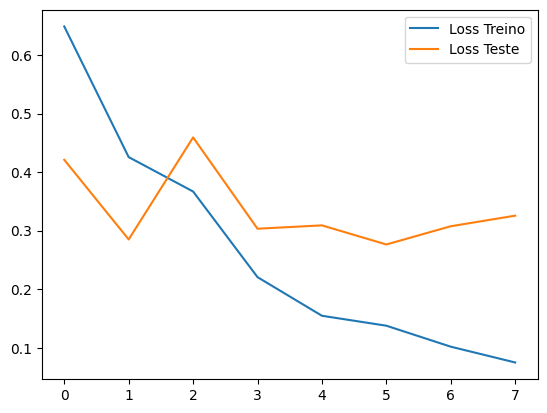

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_list_complete, label="Loss Treino")
plt.plot(test_loss_list_complete, label="Loss Teste")
plt.legend()
plt.show()

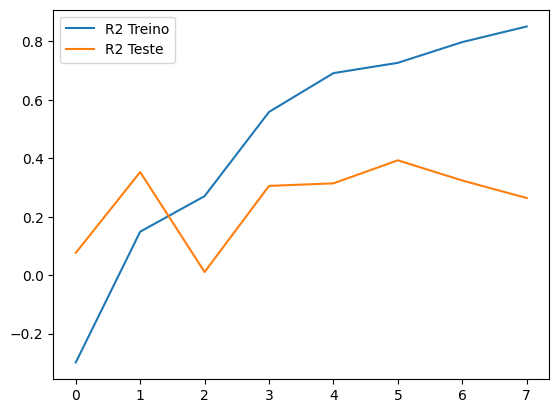

In [ ]:
plt.plot(r2_list_complete, label="R2 Treino")
plt.plot(test_r2_list_complete, label="R2 Teste")
plt.legend()
plt.show()